mount google drive

In [1]:
from google.colab import drive

# unmount first if already mounted
drive.flush_and_unmount()

# mount the drive again
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


necessary imports

In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 71.1 MB/s eta 0:00:00


In [3]:
import os
import shutil
import re
import random
import numpy as np
import cv2
import sys
import mediapipe as mp
import imageio
import h5py
import logging
import multiprocessing

from PIL import Image, ImageEnhance, ImageSequence
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import LossScaleOptimizer, set_global_policy
from tensorflow.keras.models import load_model

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


data folders

In [4]:
input_folder = "/content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_chosen/"
input_2_folder = "/content/drive/MyDrive/Colab Notebooks/Data/sgsl_recorded/"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/"

# create output directory if it does not exist
os.makedirs(output_folder, exist_ok = True)

# Augment Data

augment functions

In [ ]:
def random_rotate(image):
  # slightly rotate the image randomly within +- 10 degrees
  angle = random.uniform(-10, 10)
  return image.rotate(angle, resample = Image.BICUBIC, fillcolor = (0, 0, 0, 0))

def random_brightness(image):
  # adjust brightness - slightly darken or brighten
  enhancer = ImageEnhance.Brightness(image)
  factor = random.uniform(0.7, 1.3)
  return enhancer.enhance(factor)

def random_contrast(image):
  # adjust contrast slightly
  enhancer = ImageEnhance.Contrast(image)
  factor = random.uniform(0.7, 1.3)
  return enhancer.enhance(factor)

def random_translate(image):
  # translate image slightly - shift max 10 pixels along the x and/or y axis
  max_shift = 10
  dx, dy = random.randint(-max_shift, max_shift), random.randint(-max_shift, max_shift)
  return image.transform(image.size, Image.AFFINE, (1, 0, dx, 0, 1, dy))

def random_sharpness(image):
  # adjust sharpness - make the image more or less sharp
  enhancer = ImageEnhance.Sharpness(image)
  factor = random.uniform(0.7, 1.3)
  return enhancer.enhance(factor)

def random_saturation(image):
  # adjust saturation - make the colors more or less vivid
  enhancer = ImageEnhance.Color(image)
  factor = random.uniform(0.7, 1.3)
  return enhancer.enhance(factor)

def random_noise(image):
  # add more noticeable random noise to the image - simulates poor lighting or noisy environments
  np_image = np.array(image)
  noise = np.random.normal(0, 10, np_image.shape)
  noisy_image = np_image + noise
  noisy_image = np.clip(noisy_image, 0, 255)
  return Image.fromarray(noisy_image.astype(np.uint8))

process data and apply augmentation functions

In [ ]:
def extract_uppercase_name(filename):
  # extracts only the uppercase words at the front of the file - name of the gestures
  base_name = os.path.basename(filename).split('.')[0]  # get only the name without extenstion
  match = re.match(r'^([A-Z_]+)', base_name) # get uppercase words at the start
  return match.group(1) if match else base_name  # return words or not return whole name

# apply agumentation to gif and save - save original + 29 different variations of the data for training
def augment_gif(input_path, output_path, num_variations = 29, frame_skip = 5):
  gif = Image.open(input_path)
  frames = [frame.convert("RGBA").copy() for frame in ImageSequence.Iterator(gif)]  # extract frames and ensure in RGBA format (prevent glitches or distortions)

  class_filename = extract_uppercase_name(input_path)

  # save the original GIF
  original_save_path = os.path.join(output_path, f"{class_filename}_original.gif")
  frames[0].save(original_save_path, save_all = True, append_images = frames[1:], duration = gif.info['duration'], loop = 0)

  # generate augmented GIFs
  for i in range(num_variations):
      augmented_frames = []

      for idx, frame in enumerate(frames):
        frame = frame.convert("RGB")  # Convert to RGB format

        # apply augmentation only every 'frame_skip' frames
        if idx % frame_skip == 0:
          frame = random_rotate(frame)
          frame = random_brightness(frame)
          frame = random_contrast(frame)
          frame = random_translate(frame)
          frame = random_sharpness(frame)
          frame = random_saturation(frame)
          frame = random_noise(frame)

        augmented_frames.append(frame)

      # save augmented GIF
      save_path = os.path.join(output_path, f"{class_filename}_aug_{i}.gif")
      augmented_frames[0].save(save_path, save_all = True, append_images = augmented_frames[1:], duration = gif.info['duration'], loop = 0)

# function to process multiple GIFs in parallel
def process_gif(args):
    input_path, output_path, num_variations = args
    augment_gif(input_path, output_path, num_variations)

# function to process and update the tqdm progress bar
def process_gif_and_update_bar(input_path, output_path, num_variations, pbar):
    augment_gif(input_path, output_path, num_variations)
    pbar.update(1)  # update progress bar after processing each file

# function to augment gifs using threadpoolexecutor for parallel processing with tqdm
def augment_gifs_in_parallel(gif_files, output_path, num_variations = 29, num_workers = 4):
    with tqdm(total = len(gif_files), desc = "Processing GIFs", unit = "file") as pbar:
        # Use threadpoolexecutor instead of multiprocessing Pool
        with ThreadPoolExecutor(max_workers = num_workers) as executor:
            futures = []
            for input_path, file in gif_files:
                futures.append(executor.submit(process_gif_and_update_bar, input_path, output_path, num_variations, pbar))

            # wait for all futures to complete
            for future in as_completed(futures):
                future.result()  # get the result to handle exceptions if any

process all the gifs in the data folder

In [ ]:
# get all gif files from both input folders
gif_files = [(os.path.join(input_folder, file), file) for file in os.listdir(input_folder) if file.endswith(".gif")]
gif_files += [(os.path.join(input_2_folder, file), file) for file in os.listdir(input_2_folder) if file.endswith(".gif")]

# run the augmentation process in parallel with tqdm progress bar
augment_gifs_in_parallel(gif_files, output_folder, num_variations = 29, num_workers = 4)

print("Augmentation completed! Augmented GIFs saved in:", output_folder)

Processing GIFs: 100%|██████████| 64/64 [59:55<00:00, 56.18s/file]

Augmentation completed! Augmented GIFs saved in: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/


In [ ]:
# get the total number of gifs from the augmented dataset (total number of data)
augmented_gifs = [file for file in os.listdir(output_folder) if file.endswith(".gif")]

print("\nTotal number of GIFs in the dataset:", len(augmented_gifs))


Total number of GIFs in the dataset: 1920


# Preprocess Data for Model

In [5]:
# initialize mediapipe hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode = False, max_num_hands = 2, min_detection_confidence = 0.5)

class SGSL_Dataset(keras.utils.Sequence):
    def __init__(self, folder, batch_size = 32, max_frames = 40, preprocess_file = None):
        self.folder = folder
        self.batch_size = batch_size
        self.max_frames = max_frames
        self.preprocess_file = preprocess_file

        # gather all the GIF files from the folder
        self.gif_files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith(".gif")]

        # extract labels from the file names and store them
        self.labels = self._extract_labels()

        # create sorted list of unique labels
        self.unique_labels = sorted(set(self.labels.values()))

        # maps each unique label to an integer index
        self.label_to_index = {label: i for i, label in enumerate(self.unique_labels)}

        # total number of unique labels (classes)
        self.num_classes = len(self.unique_labels)

        # if preprocess_file is provided, load the preprocessed data
        if self.preprocess_file:
            self.preprocessed_data = self.load_preprocessed_data()
        else:
            self.preprocessed_data = None  # no preprocessed data loaded

    def _extract_labels(self):
        # extract capitalized words from the GIF files names as the label
        labels = {}
        for file in self.gif_files:
            filename = os.path.basename(file).split('.')[0]
            # split the filename by underscores and get the capitalized words
            words = filename.split('_')
            # filter only the words that are all uppercase letters
            capitalized_words = [word for word in words if word.isupper()]
            # concatenate the capitalized words into a single label string
            label = " ".join(capitalized_words) if capitalized_words else "Unknown"
            labels[file] = label
        return labels

    def __len__(self):
        # returns the total number of batches
        return int(np.ceil(len(self.gif_files) / self.batch_size))

    def preprocess_gif(self, gif_path):
        # preprocess gif by extracting the frames, resizing them, and extracting hand landmarks
        # gif = Image.open(gif_path)  # open gif using pil
        print((f"Processing GIF: {gif_path}"))
        landmarks = []  # to store the hand landmarks for each frame

        # extract frames from the GIF using imageio
        gif_frames = imageio.mimread(gif_path, memtest = False)
        print(f"Total frames in GIF: {len(gif_frames)}")

        # read frames until max frames
        for idx, frame in enumerate(gif_frames[:self.max_frames]):
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # convert to bgr for opencv

            # process the frame with mediapipe hands
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb_frame)

            # initialize frame_landmarks with 84 zeros (42 landmarks for each hand)
            frame_landmarks = np.zeros(84)

            # process the detected hand landmarks
            if results.multi_hand_landmarks:
                for i, hand_landmarks in enumerate(results.multi_hand_landmarks):

                  # only process up to two hands
                  if i >= 2:
                      break

                  if hand_landmarks:  # check if the hand landmarks are available
                      # extract (x, y) coordinates for each landmark
                      landmarks_for_hand = np.array([[landmark.x, landmark.y] for landmark in hand_landmarks.landmark])

                      # normalize landmarks using wrist position
                      wrist = landmarks_for_hand[0]
                      landmarks_for_hand -= wrist # normalize by subtracting wrist coordinates
                      landmarks_for_hand /= np.linalg.norm(landmarks_for_hand) + 1e-6 # normalize scale

                      # assign landmarks to the corresponding part of frame_landmarks
                      start_idx = i * 42  # for first hand, it starts from index 0, for second hand, it starts from 42
                      frame_landmarks[start_idx:start_idx + 42] = landmarks_for_hand.flatten()


            landmarks.append(frame_landmarks)

        # create landmarks to pad if there are fewer frames
        while len(landmarks) < self.max_frames:
            landmarks.append(np.zeros(84))

        # convert landmarks to numpy arrays
        landmarks = np.array(landmarks)

        return landmarks

    def preprocess_and_store(self, output_file):
      # open an HDF5 file for writing
      with h5py.File(output_file, 'w') as hf:
          for i, file in enumerate(self.gif_files):
              print(f"Processing GIF {i + 1}/{len(self.gif_files)}: {file}")
              landmarks = self.preprocess_gif(file)

              # create a group for each gif file
              group_name = os.path.basename(file)  # use the basename (e.g., SEA_aug_31.gif) as the group name
              group = hf.create_group(group_name)
              group.create_dataset('landmarks', data = landmarks)
              group.attrs['label'] = self.labels[file]  # store the label as an attribute

      print(f"Preprocessed data saved to {output_file}")

    def load_preprocessed_data(self):
      if os.path.exists(self.preprocess_file):
          preprocessed_data = {}
          with h5py.File(self.preprocess_file, 'r') as hf:
              for file in hf.keys():
                  group = hf[file]
                  preprocessed_data[file] = {
                      'landmarks': group['landmarks'][:],  # load landmarks
                      'label': group.attrs['label']  # load label
                  }
          return preprocessed_data
      else:
          raise FileNotFoundError(f"Preprocessed file {self.preprocess_file} not found!")

    def __getitem__(self, idx):
        # fetch batches of data for training
        batch_files = self.gif_files[idx * self.batch_size: (idx + 1) * self.batch_size]

        batch_landmarks = []

        # if preprocessed data is loaded, just fetch from it
        if self.preprocessed_data:
            for file in batch_files:
                data = self.preprocessed_data[file]
                batch_landmarks.append(data['landmarks'])
        else:
            # if not preprocessed, preprocess on the fly
            for file in batch_files:
                landmarks = self.preprocess_gif(file)
                batch_landmarks.append(landmarks)

        # convert to numpy arrays
        batch_landmarks = np.array(batch_landmarks)

        # extract the corresponding labels for each file in the batch
        batch_labels = [self.labels[file] for file in batch_files]

        # convert labels to their integer index values
        batch_labels = np.array([self.label_to_index[label] for label in batch_labels])

        return batch_landmarks, keras.utils.to_categorical(batch_labels, num_classes = self.num_classes)

    def print_dataset_info(self):
        print(f"Number of unique labels (classes): {self.num_classes}")
        print(f"Class distribution: {dict(zip(self.unique_labels, [list(self.labels.values()).count(label) for label in self.unique_labels]))}")


In [6]:
batch_size = 16
dataset = SGSL_Dataset(folder = output_folder, batch_size = batch_size)

# work on training dataset first to not have memory overload

# print dataset info
dataset.print_dataset_info()

# split the dataset into training and validation sets
indices = np.arange(len(dataset.gif_files))
train_indices, val_indices = train_test_split(indices, test_size = 0.2, random_state = 42)

# select GIF file paths for training and validation sets
train_gif_files = [dataset.gif_files[i] for i in train_indices]

# create dictionaries mapping file paths to their corresponding labels
train_labels = {file: dataset.labels[file] for file in train_gif_files}

# create training dataset
train_dataset = SGSL_Dataset(folder = output_folder, batch_size = batch_size)
train_dataset.gif_files = train_gif_files
train_dataset.labels = train_labels
train_dataset.preprocess_and_store("/content/drive/MyDrive/Colab Notebooks/Data/train_data.h5")

# print dataset info
print("\nTraining Dataset Info:")
train_dataset.print_dataset_info()

Number of unique labels (classes): 63
Class distribution: {'A': 30, 'B': 30, 'BOOK': 30, 'BRING': 30, 'BUY': 30, 'C': 30, 'CAKE': 30, 'COFFEE': 30, 'COOK': 30, 'D': 30, 'DRINK': 30, 'E': 30, 'EAT': 30, 'F': 30, 'FEEL': 30, 'FIND': 30, 'FOOD': 30, 'G': 30, 'GIVE': 30, 'GO': 30, 'H': 30, 'HELLO': 30, 'HELP': 30, 'HOTEL': 30, 'HOW ARE YOU': 30, 'I': 60, 'J': 30, 'K': 30, 'KNOW': 30, 'L': 30, 'LEARN': 30, 'LIBRARY': 30, 'LIKE': 30, 'M': 30, 'MAKE': 30, 'MONEY': 30, 'MORNING': 30, 'MY': 30, 'N': 30, 'O': 30, 'P': 30, 'PARK': 30, 'Q': 30, 'R': 30, 'READ': 30, 'S': 30, 'SCHOOL': 30, 'SEE': 30, 'SHE': 30, 'SHOP': 30, 'T': 30, 'TEA': 30, 'THEM': 30, 'U': 30, 'V': 30, 'W': 30, 'WATER': 30, 'WRITE': 30, 'X': 30, 'Y': 30, 'YOU': 30, 'YOURS': 30, 'Z': 30}
Processing GIF 1/1536: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/I_aug_9.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/I_aug_9.gif
Total frames in GIF: 38
Processing GIF 2/1536: /content/dr

In [7]:
# load the remaining validation set

batch_size = 16
dataset = SGSL_Dataset(folder = output_folder, batch_size = batch_size)

# load the training dataset to get successfully processed gifs
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Data/train_data.h5"
if os.path.exists(train_data_path):
    with h5py.File(train_data_path, 'r') as train_data:
        processed_train_gifs = set(train_data.keys())  # set of training processed gifs
else:
    raise FileNotFoundError(f"Training dataset {train_data_path} not found!")

# get the remaining gifs for validation
remaining_gifs = [gif for gif in dataset.gif_files if gif.split('/')[-1] not in processed_train_gifs]

# update validation dataset only with remaining gifs
val_dataset = SGSL_Dataset(folder = output_folder, batch_size = batch_size)
val_dataset.gif_files = remaining_gifs
val_dataset.labels = {file: dataset.labels[file] for file in remaining_gifs}

# process and store the remaining validation dataset
val_data_path = "/content/drive/MyDrive/Colab Notebooks/Data/val_data.h5"
val_dataset.preprocess_and_store(val_data_path)

# print final validation dataset info
print("\nValidation Dataset Info (Processed Remaining GIFs):")
val_dataset.print_dataset_info()

Processing GIF 1/384: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/A_aug_11.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/A_aug_11.gif
Total frames in GIF: 149
Processing GIF 2/384: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/C_aug_10.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/C_aug_10.gif
Total frames in GIF: 164
Processing GIF 3/384: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/B_aug_11.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/B_aug_11.gif
Total frames in GIF: 165
Processing GIF 4/384: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/D_aug_11.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/D_aug_11.gif
Total frames in GIF: 135
Processing GIF 5/384: /content/drive/MyDrive/Colab Notebooks/Data/ntu_sgsl_augmented/A_aug_16.gif
Processing GIF: /content/drive/MyDrive/Col

# Training the model: 1D + Transformer Model

In [8]:
# enable mixed precision for faster training on GPUs
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
set_global_policy("mixed_float16")

# transformer block
def transformer_block(x, num_heads = 4, ff_dim = 256, dropout_rate = 0.4):

    # multi-head attention
    attention_output = layers.MultiHeadAttention(num_heads = num_heads, key_dim = ff_dim)(x, x)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x = layers.LayerNormalization(epsilon = 1e-6)(attention_output + x)

    # feed forward network (mlp)
    ff_output = layers.Dense(x.shape[-1], activation = 'gelu')(x)
    ff_output = layers.Dropout(dropout_rate)(ff_output)
    x = layers.LayerNormalization(epsilon = 1e-6)(x + ff_output)

    return x

# 1d cnn + transformer model
def create_model(input_shape, num_classes):
    inputs = Input(shape=(input_shape[0], 1))  # reshape for conv1d

    # 1d convolutional layers
    x = layers.Conv1D(128, kernel_size = 5, activation = 'relu', padding = 'same')(inputs)
    x = layers.Conv1D(256, kernel_size = 3, activation = 'relu', padding = 'same')(x)
    x = layers.MaxPooling1D(pool_size = 2)(x)
    x = layers.Dropout(0.4)(x)

    # transformer block
    x = transformer_block(x, num_heads = 4, ff_dim = 256, dropout_rate = 0.4)
    x = transformer_block(x, num_heads = 4, ff_dim = 256, dropout_rate = 0.4)

    # flatten and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation = 'silu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation = 'softmax')(x)

    optimizer = AdamW(learning_rate = 0.001, weight_decay = 1e-4)

    model = Model(inputs, outputs)
    model.compile(optimizer = optimizer, loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['sparse_categorical_accuracy'])

    return model

# dataset loader
def load_dataset_efficient(h5_file, batch_size = 16, shuffle = True):
    # read all labels and create a mapping from class names to integer indices
    with h5py.File(h5_file, 'r') as hf:
        all_labels = [hf[k].attrs['label'].decode() if isinstance(hf[k].attrs['label'], bytes) else hf[k].attrs['label'] for k in hf.keys()]
        class_names = sorted(set(all_labels))  # get unique class names, sorted
        class_to_index = {name: idx for idx, name in enumerate(class_names)}  # mapping

    num_classes = len(class_names)  # total number of classes

    def data_generator():
        with h5py.File(h5_file, 'r') as hf:
            keys = list(hf.keys())
            if shuffle:
                np.random.shuffle(keys)

            for file in keys:
                group = hf[file]
                landmarks = group['landmarks'][:]
                label = group.attrs['label']  # read as string

                # convert label from string to integer index
                label_idx = class_to_index[label]

                # flatten landmarks
                feature = landmarks.flatten()

                yield feature, label_idx

    # get input shape from the first sample
    with h5py.File(h5_file, 'r') as hf:
        first_key = list(hf.keys())[0]
        input_shape = hf[first_key]['landmarks'][:].flatten().shape

    # create tf.data.Dataset
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape = input_shape, dtype = tf.float32),
            tf.TensorSpec(shape = (), dtype = tf.int32)
        )
    )

    # apply shuffling, batching, and prefetching
    if shuffle:
        dataset = dataset.shuffle(buffer_size = 1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, num_classes, input_shape, class_names

class PrintMetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs = None):
        print(f"\nEpoch {epoch+1}: Training Accuracy = {logs['sparse_categorical_accuracy']:.4f}, Validation Accuracy = {logs['val_sparse_categorical_accuracy']:.4f}")


# load datasets
train_h5_path = "/content/drive/MyDrive/Colab Notebooks/Data/train_data.h5"
val_h5_path = "/content/drive/MyDrive/Colab Notebooks/Data/val_data.h5"

train_dataset, num_classes, input_shape, class_names = load_dataset_efficient(train_h5_path, batch_size = 32)
val_dataset, _, _, _ = load_dataset_efficient(val_h5_path, batch_size = 32, shuffle = False)

# create model
model = create_model(input_shape, num_classes)

# callbacks
callbacks = [
    ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Data/model_best.keras", save_best_only = True, monitor = 'val_sparse_categorical_accuracy', mode = 'max'),
    ReduceLROnPlateau(monitor = 'val_sparse_categorical_accuracy', factor = 0.7, patience = 5, mode = "max", min_lr = 1e-6),
    PrintMetricsCallback()
]

# train the model
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 150,
    callbacks = callbacks
)



Epoch 1/150
     48/Unknown 51s 244ms/step - loss: 4.2742 - sparse_categorical_accuracy: 0.0172

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: Training Accuracy = 0.0182, Validation Accuracy = 0.0286
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 341ms/step - loss: 4.2733 - sparse_categorical_accuracy: 0.0172 - val_loss: 4.1865 - val_sparse_categorical_accuracy: 0.0286 - learning_rate: 0.0010
Epoch 2/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 4.0203 - sparse_categorical_accuracy: 0.0373
Epoch 2: Training Accuracy = 0.0449, Validation Accuracy = 0.1016
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - loss: 4.0178 - sparse_categorical_accuracy: 0.0375 - val_loss: 3.8258 - val_sparse_categorical_accuracy: 0.1016 - learning_rate: 0.0010
Epoch 3/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 3.4641 - sparse_categorical_accuracy: 0.1002
Epoch 3: Training Accuracy = 0.1217, Validation Accuracy = 0.1536
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - loss: 3.4615 - sparse_categorical_accuracy: 0.1007 - val_loss: 3.7869 - val_sparse_categorical_accuracy: 0.1536 - learning_rate: 0.0010
Epoch 4/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/s

save the model history

In [9]:
with open("/content/drive/MyDrive/Colab Notebooks/Data/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Testing the Model

preparing the test dataset

In [11]:
def extract_uppercase_name(filename):
  # extracts only the uppercase words at the front of the file - name of the gestures
  base_name = os.path.basename(filename).split('.')[0]  # get only the name without extenstion
  match = re.match(r'^([A-Z_]+)', base_name) # get uppercase words at the start
  return match.group(1) if match else base_name  # return words or not return whole name

def create_test_set(gif_files, output_folder, samples_per_file = 30):
    # create the output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # loop through each file in the input gif files list
    for file_path, file_name in gif_files:
        # extract the base name
        base_name = extract_uppercase_name(file_name)

        # create 30 copies of each file
        for i in range(samples_per_file):
            # generate a new name with suffix
            new_file_name = f"{base_name}_test_{i+1}.gif"
            dest_path = os.path.join(output_folder, new_file_name)

            # copy the file with the new name
            shutil.copy(file_path, dest_path)

        print(f"Copied {samples_per_file} copies of {file_name} to {output_folder}")

# get all gif files from both input folders
gif_files = [(os.path.join(input_folder, file), file) for file in os.listdir(input_folder) if file.endswith(".gif")]
gif_files += [(os.path.join(input_2_folder, file), file) for file in os.listdir(input_2_folder) if file.endswith(".gif")]

# output test folder
output_test_folder = "/content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/"

create_test_set(gif_files, output_test_folder, samples_per_file = 30)

Copied 30 copies of FIND.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of BOOK_(n).gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of FOOD.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of EATa.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of COOK_(Verb).gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of DRINKa.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of BRING.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of COFFEE.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of BUY-Ao.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of CAKE.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of FEEL.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of LEARN

In [12]:
# output test folder
output_test_folder = "/content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/"

# get data from both test ouput folder
test_dataset = SGSL_Dataset(folder = output_test_folder, batch_size = 32, max_frames = 40)

# preprocess and store the testing data
test_dataset.preprocess_and_store("/content/drive/MyDrive/Colab Notebooks/Data/test_data.h5")

# print information about the dataset
test_dataset.print_dataset_info()

Streaming output truncated to the last 5000 lines.
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/BUY_test_15.gif
Total frames in GIF: 33
Processing GIF 256/1920: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/BUY_test_16.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/BUY_test_16.gif
Total frames in GIF: 33
Processing GIF 257/1920: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/BUY_test_17.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/BUY_test_17.gif
Total frames in GIF: 33
Processing GIF 258/1920: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/BUY_test_18.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/BUY_test_18.gif
Total frames in GIF: 33
Processing GIF 259/1920: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/BUY_test_19.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/BUY_test_19.gif
Total frames in GIF: 33
Processing GIF 260/

load model and test

In [13]:
# dataset loader
def load_dataset_efficient(h5_file, batch_size = 16, shuffle = True):
    # read all labels and create a mapping from class names to integer indices
    with h5py.File(h5_file, 'r') as hf:
        all_labels = [hf[k].attrs['label'].decode() if isinstance(hf[k].attrs['label'], bytes) else hf[k].attrs['label'] for k in hf.keys()]
        class_names = sorted(set(all_labels))  # get unique class names, sorted
        class_to_index = {name: idx for idx, name in enumerate(class_names)}  # mapping

    num_classes = len(class_names)  # total number of classes

    def data_generator():
        with h5py.File(h5_file, 'r') as hf:
            keys = list(hf.keys())
            if shuffle:
                np.random.shuffle(keys)

            for file in keys:
                group = hf[file]
                landmarks = group['landmarks'][:]
                label = group.attrs['label']  # read as string

                # convert label from string to integer index
                label_idx = class_to_index[label]

                # flatten frames and landmarks, then concatenate
                feature = landmarks.flatten()

                yield feature, label_idx

    # get input shape from the first sample
    with h5py.File(h5_file, 'r') as hf:
        first_key = list(hf.keys())[0]
        input_shape = hf[first_key]['landmarks'][:].flatten().shape

    # create tf.data.Dataset
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape = input_shape, dtype = tf.float32),
            tf.TensorSpec(shape = (), dtype = tf.int32)
        )
    )

    # apply shuffling, batching, and prefetching
    if shuffle:
        dataset = dataset.shuffle(buffer_size = 1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, num_classes, input_shape, class_names


# load test dataset
test_h5_path = "/content/drive/MyDrive/Colab Notebooks/Data/test_data.h5"

test_dataset, num_classes, input_shape, class_names = load_dataset_efficient(test_h5_path, batch_size = 32, shuffle = False)

# load the saved model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Data/model_best.keras')

# evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, verbose = 1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - loss: 0.0144 - sparse_categorical_accuracy: 0.9944
Test Loss: 0.030573634430766106
Test Accuracy: 0.984375


# Model Visualizations

load history and model

In [14]:
# load the training history
history_path = "/content/drive/MyDrive/Colab Notebooks/Data/history.pkl"
with open(history_path, "rb") as f:
    history = pickle.load(f)

# load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Data/model_best.keras")

# dataset loader
def load_dataset_efficient(h5_file, batch_size = 16, shuffle = True):
    # read all labels and create a mapping from class names to integer indices
    with h5py.File(h5_file, 'r') as hf:
        all_labels = [hf[k].attrs['label'].decode() if isinstance(hf[k].attrs['label'], bytes) else hf[k].attrs['label'] for k in hf.keys()]
        class_names = sorted(set(all_labels))  # get unique class names, sorted
        class_to_index = {name: idx for idx, name in enumerate(class_names)}  # mapping

    num_classes = len(class_names)  # total number of classes

    def data_generator():
        with h5py.File(h5_file, 'r') as hf:
            keys = list(hf.keys())
            if shuffle:
                np.random.shuffle(keys)

            for file in keys:
                group = hf[file]
                landmarks = group['landmarks'][:]
                label = group.attrs['label']  # read as string

                # convert label from string to integer index
                label_idx = class_to_index[label]

                # flatten frames and landmarks, then concatenate
                feature = landmarks.flatten()

                yield feature, label_idx

    # get input shape from the first sample
    with h5py.File(h5_file, 'r') as hf:
        first_key = list(hf.keys())[0]
        input_shape = hf[first_key]['landmarks'][:].flatten().shape

    # create tf.data.Dataset
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape = input_shape, dtype = tf.float32),
            tf.TensorSpec(shape = (), dtype = tf.int32)
        )
    )

    # apply shuffling, batching, and prefetching
    if shuffle:
        dataset = dataset.shuffle(buffer_size = 1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, num_classes, input_shape, class_names

# load test dataset
test_h5_path = "/content/drive/MyDrive/Colab Notebooks/Data/test_data.h5"  # Update with the correct path to your test data
test_dataset, _, _, class_names = load_dataset_efficient(test_h5_path, batch_size = 32, shuffle = False)

# get ground truth and predictions
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset:
    preds = model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis = 1))
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

training vs validation accuracy

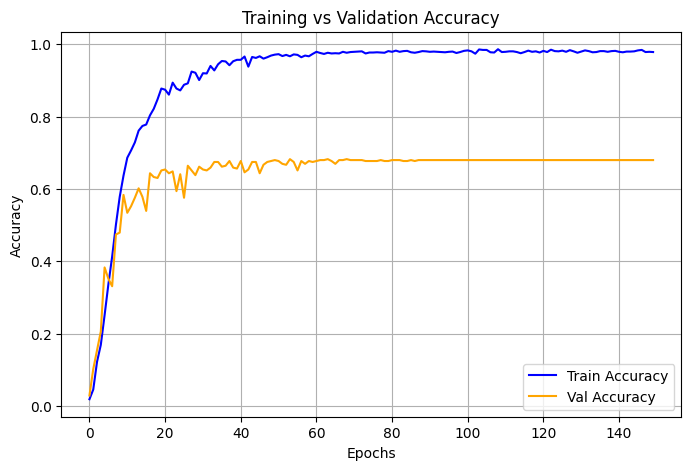

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(history['sparse_categorical_accuracy'], label = "Train Accuracy", color = 'blue')
plt.plot(history['val_sparse_categorical_accuracy'], label = "Val Accuracy", color = 'orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

training vs validation loss

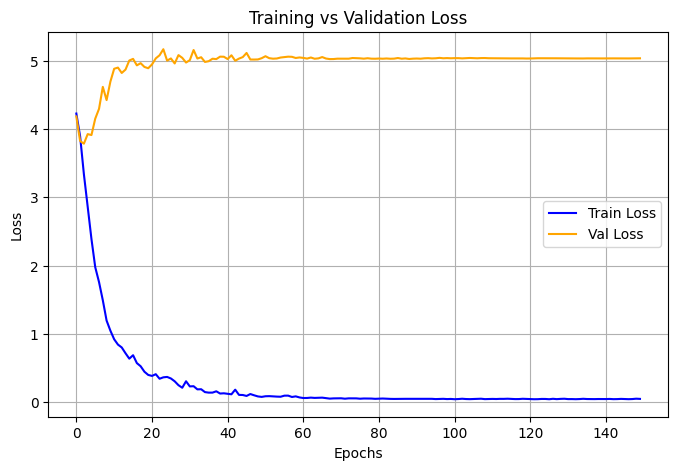

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label = "Train Loss", color = 'blue')
plt.plot(history['val_loss'], label = "Val Loss", color = 'orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

confusion matrix

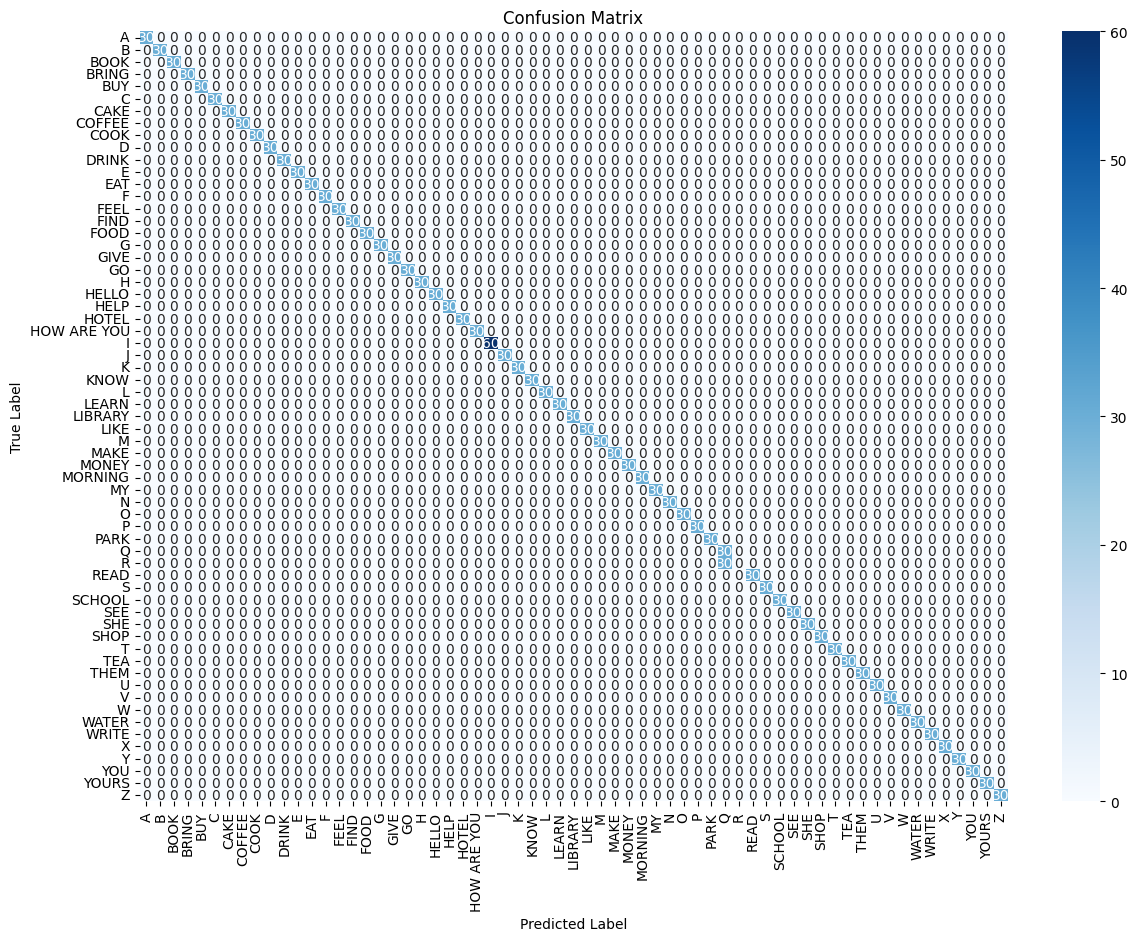

In [17]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize = (14, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

classification report

In [18]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names = class_names))

Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        30
           B       1.00      1.00      1.00        30
        BOOK       1.00      1.00      1.00        30
       BRING       1.00      1.00      1.00        30
         BUY       1.00      1.00      1.00        30
           C       1.00      1.00      1.00        30
        CAKE       1.00      1.00      1.00        30
      COFFEE       1.00      1.00      1.00        30
        COOK       1.00      1.00      1.00        30
           D       1.00      1.00      1.00        30
       DRINK       1.00      1.00      1.00        30
           E       1.00      1.00      1.00        30
         EAT       1.00      1.00      1.00        30
           F       1.00      1.00      1.00        30
        FEEL       1.00      1.00      1.00        30
        FIND       1.00      1.00      1.00        30
        FOOD       1.00      1.00      1.00        30
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


learning rate vs accuracy

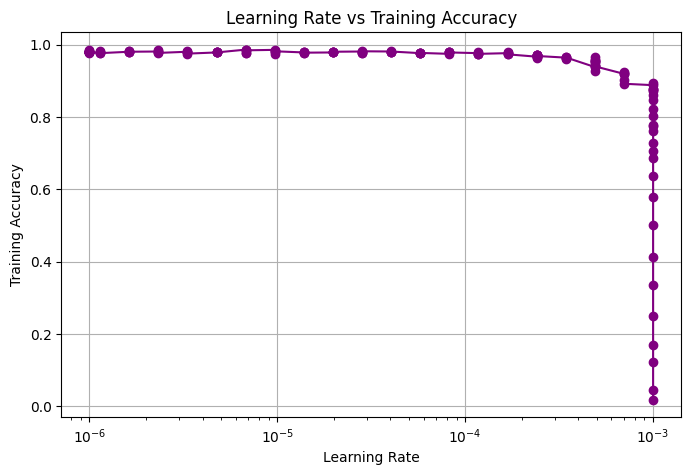

In [19]:
if 'learning_rate' in history:
    plt.figure(figsize = (8, 5))
    plt.plot(history['learning_rate'], history['sparse_categorical_accuracy'], marker = 'o', linestyle = '-', color = 'purple')
    plt.xlabel("Learning Rate")
    plt.ylabel("Training Accuracy")
    plt.xscale('log')  # log scale to better visualize LR changes
    plt.title("Learning Rate vs Training Accuracy")
    plt.grid()
    plt.show()
else:
    print("Learning rate data is not available in history.")
